# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

# Разбор урока

# Задание 1
Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). 

Опишите, какой результата вы получили? 

Что помогло вам улучшить ее точность?

## Решение
Пострим нейронную сеть LSTM на произвольном тексте.

Очень хотелось попробовать русский текст. Пробовал несколько художественных вариантов. "Сказ про Федота Стрельца" Филатова. Но получилось очень плохо. Пробовал "Тихий Дон" Шолохова. Но Google Colab сказал, что я прошу слишком много бесплатных ресурсво. И памяти не хватило. Попроболвал "Потерявший лицо" Джека Лондона. Но тоже ничего хорошего не получилось. В итоге понял, что лучше использвать научный текст с минимумом слов, но частым их использований. Взял статью про кошек из википедии. Получился хоть какой-то мало-мальски интересный результат. Его и привожу.

In [ ]:
import tensorflow.keras.utils as ku 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def get_experiment(source='', num_words=10000, lstm_l=10):
    
    data = open(source).read()
    corpus = data.lower().split(".")

    ##################################################
    # 
    #               Токенизаия и кодирование
    #

    tokenizer = Tokenizer(num_words=num_words)

    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1  # +1 для символа, который заменяет неизвестные слова
    print(f'total_words: {total_words}')

    # create input sequences using list of tokens
    input_sequences = []
    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        # print(n_gram_sequence)
        input_sequences.append(n_gram_sequence)

    # pad sequences
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    # create predictors and label
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

    label = ku.to_categorical(label, num_classes=total_words)    

    
    ##################################################
    # 
    #               Создание модели и обучение
    #
   
    callback = EarlyStopping(monitor='val_accuracy', patience=5) # создаем обратный вызов - callback - тут "Ранний останов"
    layers = [Embedding(total_words, 10, input_length=max_sequence_len-1),
          LSTM(lstm_l),
          Dropout(0.2),
          Dense(total_words/3*2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
          Dense(total_words, activation='softmax')
          ]

    model = Sequential(layers)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    history = model.fit(predictors, label, epochs=100, validation_split=0.25, 
                        callbacks=[callback], verbose=2)

    acc = history.history['accuracy']
    acc_v = history.history['val_accuracy']
    loss = history.history['loss']
    loss_v = history.history['val_loss']

    ##################################################
    # 
    #               Визуализация
    #

    epochs = range(len(history.history['accuracy']))

    fig, axs = plt.subplots(1, 2, figsize=(20,5))

    axs[0].plot(epochs, history.history['accuracy'], 'b', label='Train')
    axs[0].plot(epochs, history.history['val_accuracy'], 'r', label='Test')
    axs[0].title.set_text('Training Accuracy vs Validation Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()


    axs[1].plot(epochs, history.history['loss'], 'b', label='Train')
    axs[1].plot(epochs, history.history['val_loss'], 'r', label='Test')
    axs[1].title.set_text('Training Loss vs Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    
    plt.show()    

    ##################################################
    # 
    #       Попытка продолжить фразу
    #

    seed_text = "Кошка — домашнее животное"

    next_words = 10     
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        y_p = model.predict(token_list, verbose=0)
        predicted = np.argmax(y_p, axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            output_word = ""
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text) 

    ##################################################
    # 
    #       Визуализация предикта
    #

    plt.plot(y_p[0,:])   

    ##################################################
    # 
    #       Получение финальных метрик
    #

    accuracy = history.history['val_accuracy'][-1]
    loss = history.history['val_loss'][-1]

    return loss, accuracy

### Проведение экспериментов с различными длинами словваря и шириной слоя LSTM

In [ ]:
result = []

total_words: 4690
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 69, 10)            46900     
                                                                 
 lstm_4 (LSTM)               (None, 10)                840       
                                                                 
 dropout_4 (Dropout)         (None, 10)                0         
                                                                 
 dense_8 (Dense)             (None, 3126)              34386     
                                                                 
 dense_9 (Dense)             (None, 4690)              14665630  
                                                                 
Total params: 14,747,756
Trainable params: 14,747,756
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
248/248

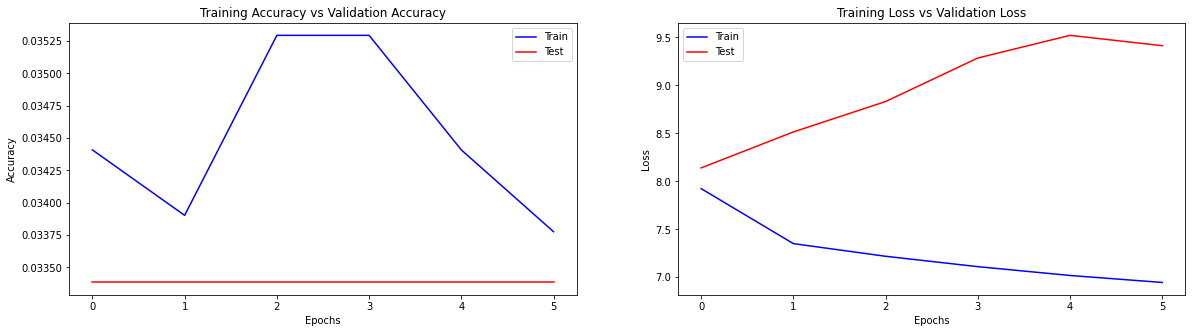

Кошка — домашнее животное и и и и и и и и и и


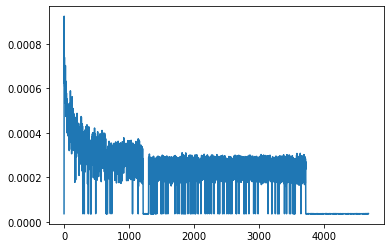

In [ ]:
loss, accuracy = get_experiment(source='Кошки.txt', num_words=10000, lstm_l=10)
result.append(['Кошки. Длина слованя: 10 000. Ширина LSTM слоя: 10', loss, accuracy])

total_words: 4690
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 69, 10)            46900     
                                                                 
 lstm_5 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 3126)              315726    
                                                                 
 dense_11 (Dense)            (None, 4690)              14665630  
                                                                 
Total params: 15,072,656
Trainable params: 15,072,656
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
248/248

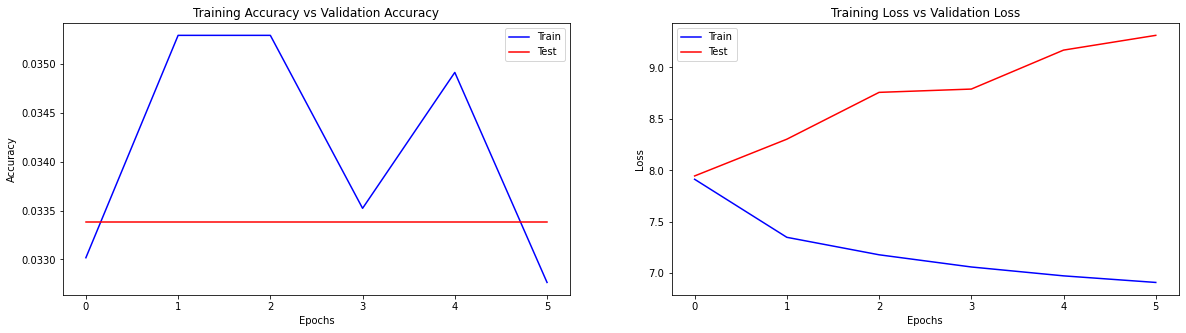

Кошка — домашнее животное и и и и и и и и и и


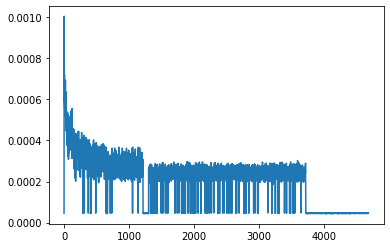

In [ ]:
loss, accuracy = get_experiment(source='Кошки.txt', num_words=10000, lstm_l=100)
result.append(['Кошки. Длина слованя: 10 000. Ширина LSTM слоя: 100', loss, accuracy])

total_words: 4690
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 36, 10)            46900     
                                                                 
 lstm_6 (LSTM)               (None, 10)                840       
                                                                 
 dropout_6 (Dropout)         (None, 10)                0         
                                                                 
 dense_12 (Dense)            (None, 3126)              34386     
                                                                 
 dense_13 (Dense)            (None, 4690)              14665630  
                                                                 
Total params: 14,747,756
Trainable params: 14,747,756
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
105/105

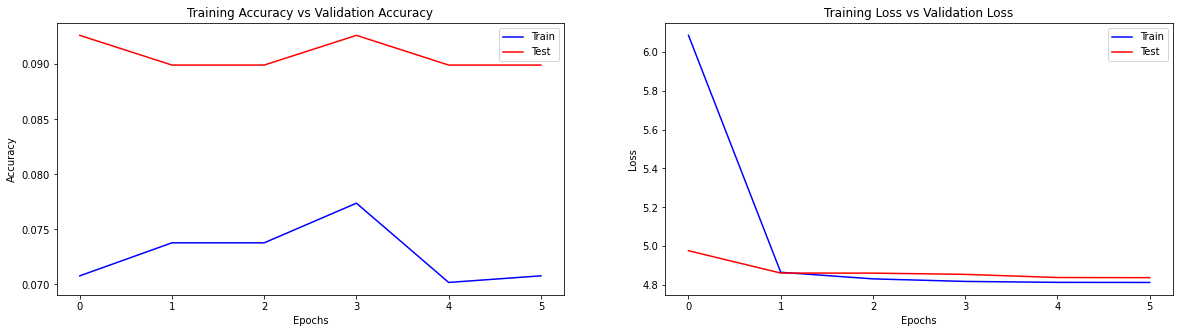

Кошка — домашнее животное и и и и и и и и и и


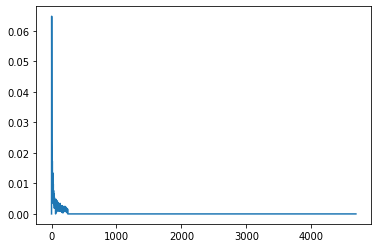

In [ ]:
loss, accuracy = get_experiment(source='Кошки.txt', num_words=250, lstm_l=10)
result.append(['Кошки. Длина слованя: 250. Ширина LSTM слоя: 10', loss, accuracy])

total_words: 4690
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 69, 10)            46900     
                                                                 
 lstm_7 (LSTM)               (None, 10)                840       
                                                                 
 dropout_7 (Dropout)         (None, 10)                0         
                                                                 
 dense_14 (Dense)            (None, 3126)              34386     
                                                                 
 dense_15 (Dense)            (None, 4690)              14665630  
                                                                 
Total params: 14,747,756
Trainable params: 14,747,756
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
248/248

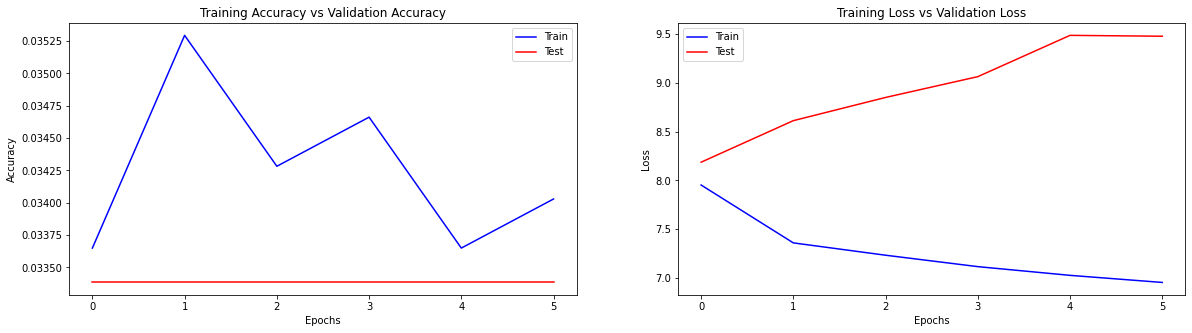

Кошка — домашнее животное и и и и и и и и и и


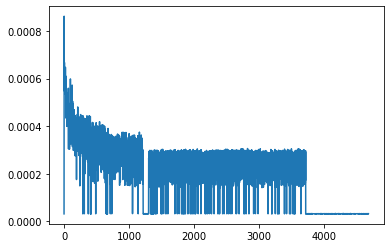

In [ ]:
loss, accuracy = get_experiment(source='Кошки.txt', num_words=100000, lstm_l=10)
result.append(['Кошки. Длина слованя: 100 000. Ширина LSTM слоя: 10', loss, accuracy])

Сравнение результатов обучения сети

In [ ]:
pd.DataFrame(result, columns=['Тест','val_loss','val_accuracy']).sort_values('val_accuracy',ascending=False)

,Тест,val_loss,val_accuracy
2,Кошки. Длина слованя: 250. Ширина LSTM слоя: 10,4.838346,0.089928
0,Кошки. Длина слованя: 10 000. Ширина LSTM слоя...,9.414038,0.033384
1,Кошки. Длина слованя: 10 000. Ширина LSTM слоя...,9.311938,0.033384
3,Кошки. Длина слованя: 100 000. Ширина LSTM сло...,9.476939,0.033384


Вывод:

Лучший результат получился у сети с малой длиной словаря. Остальные сильно отстали. Но, это скорее всего нормально для таких маленьких текстов. Продолжить предложение у всех вариантов получилось не очень удачно. Скорее всего из-за РУССКОГО языка.

Для общей проверки решил провести те-же эксперименты на общеизвестном примере с английским текстом "Алиса в стране чудес".

In [ ]:
result_aain = []

total_words: 3399
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 306, 10)           33990     
                                                                 
 lstm_8 (LSTM)               (None, 10)                840       
                                                                 
 dropout_8 (Dropout)         (None, 10)                0         
                                                                 
 dense_16 (Dense)            (None, 2266)              24926     
                                                                 
 dense_17 (Dense)            (None, 3399)              7705533   
                                                                 
Total params: 7,765,289
Trainable params: 7,765,289
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
699/699 -

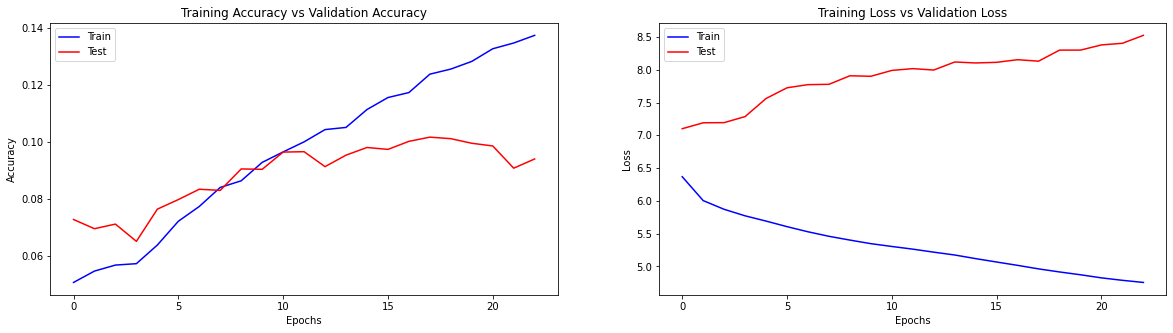

Кошка — домашнее животное time it was a little little little little little little


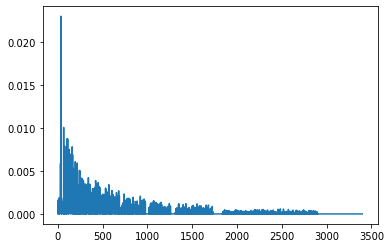

In [ ]:
loss, accuracy = get_experiment(source='AlicesAdventureInWonderland.txt', num_words=10000, lstm_l=10)
result_aain.append(['Алиса. Длина слованя: 10 000. Ширина LSTM слоя: 10', loss, accuracy])

total_words: 3399
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 306, 10)           33990     
                                                                 
 lstm_9 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 2266)              228866    
                                                                 
 dense_19 (Dense)            (None, 3399)              7705533   
                                                                 
Total params: 8,012,789
Trainable params: 8,012,789
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
699/699 -

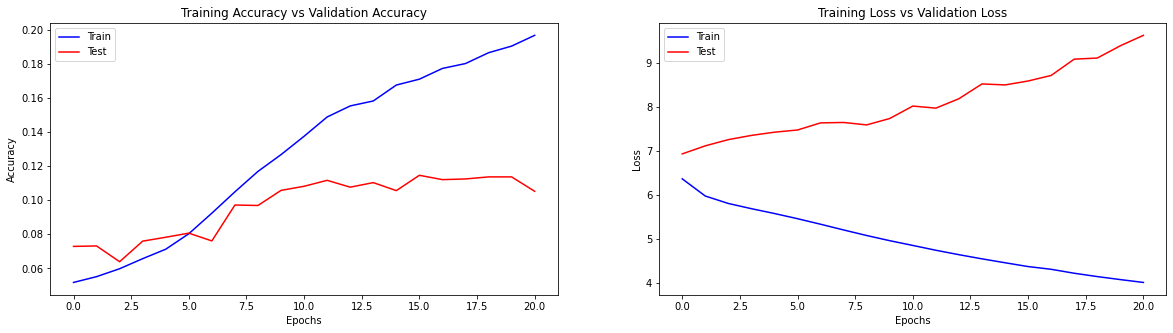

Кошка — домашнее животное the queen was a little nervous and then the other


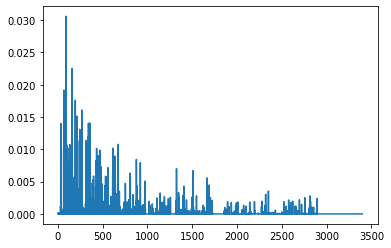

In [ ]:
loss, accuracy = get_experiment(source='AlicesAdventureInWonderland.txt', num_words=10000, lstm_l=100)
result_aain.append(['Алиса. Длина слованя: 10 000. Ширина LSTM слоя: 100', loss, accuracy])

total_words: 3399
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 219, 10)           33990     
                                                                 
 lstm_10 (LSTM)              (None, 10)                840       
                                                                 
 dropout_10 (Dropout)        (None, 10)                0         
                                                                 
 dense_20 (Dense)            (None, 2266)              24926     
                                                                 
 dense_21 (Dense)            (None, 3399)              7705533   
                                                                 
Total params: 7,765,289
Trainable params: 7,765,289
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
484/484 

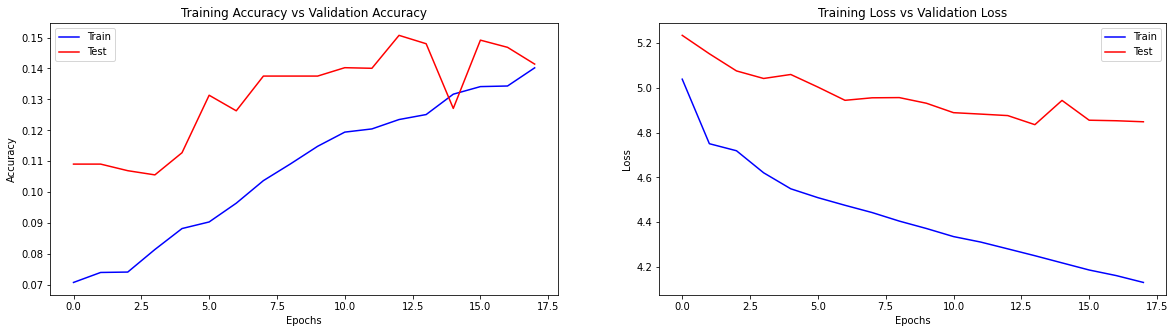

Кошка — домашнее животное ’ said alice said the mock turtle and the queen


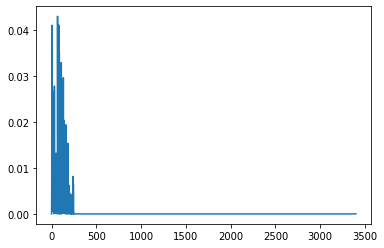

In [ ]:
loss, accuracy = get_experiment(source='AlicesAdventureInWonderland.txt', num_words=250, lstm_l=10)
result_aain.append(['Алиса. Длина слованя: 250. Ширина LSTM слоя: 10', loss, accuracy])

total_words: 3399
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 306, 10)           33990     
                                                                 
 lstm_11 (LSTM)              (None, 10)                840       
                                                                 
 dropout_11 (Dropout)        (None, 10)                0         
                                                                 
 dense_22 (Dense)            (None, 2266)              24926     
                                                                 
 dense_23 (Dense)            (None, 3399)              7705533   
                                                                 
Total params: 7,765,289
Trainable params: 7,765,289
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
699/699 

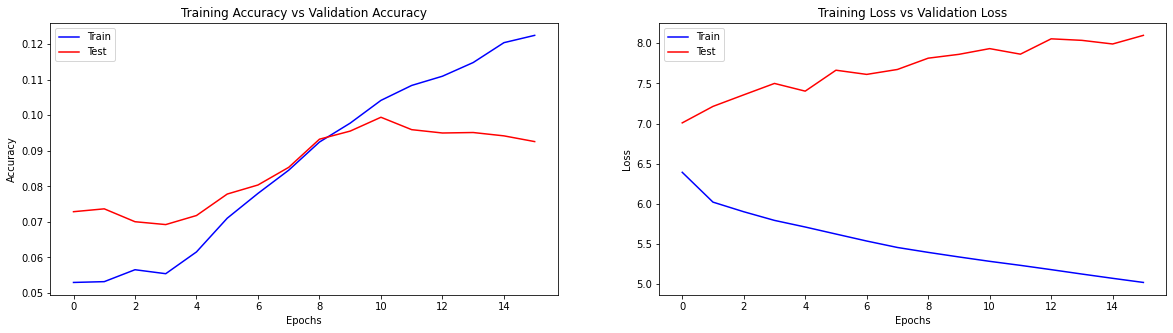

Кошка — домашнее животное be a little little little little little little little little


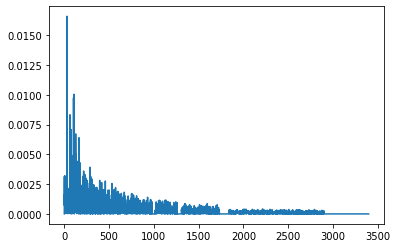

In [ ]:
loss, accuracy = get_experiment(source='AlicesAdventureInWonderland.txt', num_words=100000, lstm_l=10)
result_aain.append(['Алиса. Длина слованя: 100 000. Ширина LSTM слоя: 10', loss, accuracy])

In [ ]:
pd.DataFrame(result_aain, columns=['Тест','val_loss','val_accuracy']).sort_values('val_accuracy',ascending=False)

,Тест,val_loss,val_accuracy
2,Алиса. Длина слованя: 250. Ширина LSTM слоя: 10,4.848520,0.141418
1,Алиса. Длина слованя: 10 000. Ширина LSTM слоя...,9.621665,0.105207
0,Алиса. Длина слованя: 10 000. Ширина LSTM слоя...,8.525599,0.094069
3,Алиса. Длина слованя: 100 000. Ширина LSTM сло...,8.098225,0.092593


Результаты в несколько раз лучше, чем в случае со статьей про кошек. Но тенденция одинакова. Чем меньше словарь, тем качественне работа сети. Видимо это закономерность.